# CellAssign results

Notebook showing cellAssign results with new taxonomy from Nick.

`cell_types` composed in https://github.com/NIH-CARD/brain-taxonomy

```python
cell_types = [
    "oligo",
    "opc",
    "glutamatergic",
    "gabergic",
    "protoplasmic_astrocyte",
    "fibrous_astrocyte",
    "microglia",
    "t_cell",
    "b_cell",
    "pericyte",
    "endothelial",
    "unknown",
]
```

----


Outline:

- setup:  imports, helper_functions, data path definitions
- get predictions (fit `cellassign` model)
- assess predictions
    - clean vs. full set of samples
    - cellassign "noise" parameter:  `continuous_covariate_keys=["doublet_score", "pct_counts_mt", "pct_counts_rb"]` vs `None`
    - repititions / seeds


## setup  
- imports 
- helper_functions 
- data path definitions

In [1]:
import sys
import os

import scanpy as sc
import anndata as ad
from pathlib import Path
import scipy.sparse as sp
import pandas as pd
import numpy as np
import scvi

# %%
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append(os.path.abspath("/home/ergonyc/Projects/SingleCell/labelator/"))

In [2]:
XYLENA2_RAW_PATH = "data/scdata/xylena_raw"
XYLENA2_PATH = "data/scdata/xylena"

# FULL data is both "clean" (train+test) and "dirty" samples which were originally left out of the dataset
XYLENA2_FULL = "xyl2_full.h5ad"

In [3]:
root_path = Path.cwd().parent
data_path = root_path / XYLENA2_PATH
raw_data_path = root_path / XYLENA2_RAW_PATH

markers_path = root_path / "taxonomy/cellassign_markers.csv"
markers = pd.read_csv(markers_path, index_col=0)

In [4]:
# helper functions
def get_cell_types(adata, markers, batch_key=None, noise=None, seed=9627):
    """ """
    #  2. copy for cellassign
    # bdata = adata[:, markers.index].copy() #
    bdata = adata[:, adata.var.index.isin(markers.index)].copy()

    #  3. get size_factor and noise .  NOTE: it is imperitive to compute lib_size on the full data
    lib_size = adata.X.sum(1)  # type: ignore
    bdata.obs["size_factor"] = lib_size / np.mean(lib_size)

    #  4. model = CellAssign(bdata, marker_genes)
    scvi.external.CellAssign.setup_anndata(
        bdata,
        size_factor_key="size_factor",
        # batch_key="sample",
        batch_key=batch_key,
        layer=None,  #'counts',
        continuous_covariate_keys=noise,
    )

    #  5. model.train()
    # NOTE: highly dependent on seed... which may be a way for us to estimate the uncertainty of the ground truth prediction
    scvi.settings.seed = seed
    model = scvi.external.CellAssign(bdata, markers)
    model.train()  # use default training parameters

    #  6. model.predict()
    preds = model.predict()
    preds["cellassign_types"] = preds.idxmax(axis=1).values

    if "cell_type" not in bdata.obs_keys():
        preds["cell_type"] = "NONE"
    else:
        preds["cell_type"] = bdata.obs["cell_type"].values
    preds["sample"] = bdata.obs["sample"].values
    preds["cell"] = bdata.obs.index.values
    preds.index = preds["cell"].values

    return preds, model


def plot_confusion(
    df: pd.DataFrame,
    title_caption: str = "Confusion matrix",
    pred_key: str = "cellassign_types_A",
    cell_type_key: str = "cellassign_types_B",
):
    """Plot confusion matrix of predictions. This version is slooooow (6 seconds)

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    pred_key : str
        Key in `adata.obs` where predictions are stored. Default is `pred`.
    cell_type_key : str
        Key in `adata.obs` where cell types are stored. Default is `cell_type`.
    model_name : str
        Name of model. Default is `LBL8R`.
    title_str : str
        Additional string to add to title. Default is `""`.
    fig_dir : Path | str
        Directory to save figure to. Default is `None`.

    Returns
    -------
    None

    """
    # Calculate precision, recall, and F1-score
    prec = precision_score(df[cell_type_key], df[pred_key], average="macro")
    rec = recall_score(df[cell_type_key], df[pred_key], average="macro")
    f1 = f1_score(df[cell_type_key], df[pred_key], average="macro")
    acc = (df[pred_key] == df[cell_type_key]).mean()
    confusion_matrix = pd.crosstab(
        df[pred_key],
        df[cell_type_key],
        rownames=[f"Prediction {pred_key}"],
        colnames=[f"Ground truth {cell_type_key}"],
    )
    confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(
        confusion_matrix,
        cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
        ax=ax,
        square=True,
        cbar_kws=dict(shrink=0.4, aspect=12),
    )
    title_str = f"{acc=:3f}:  {prec=:3f}: {rec=:3f}: {f1=:3f})"
    ax.set_title(title_str.split(":"))
    plt.suptitle(title_caption)
    plt.tight_layout()


# %%


def print_count_subset(
    predictionsA: pd.DataFrame, predictionsB: pd.DataFrame, labs: list = ["A", "B"]
):

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="left", suffixes=("_A", "_B")
    )

    summary = pd.DataFrame()
    key = f"{labs[0]}pct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    key = f"{labs[1]}pct"
    summary[key] = (
        100 * predictionsB.cellassign_types.value_counts() / predictionsB.shape[0]
    )
    key = f"{labs[1]}pct_"
    summary[key] = (
        100
        * merged_predictions.cellassign_types_B.value_counts()
        / merged_predictions.shape[0]
    )

    key = f"{labs[0]}"
    summary[key] = predictionsA.cellassign_types.value_counts()
    key = f"{labs[1]}_"
    summary[key] = merged_predictions.cellassign_types_B.value_counts()

    print(
        f" N samples {labs[0]}= {predictionsA.shape[0]}, N samples {labs[1]}= {predictionsB.shape[0]}"
    )
    print(f"   (underscore `_` indicates samples matched to {labs[0]} samples)")
    print(summary)

    return summary


def print_count_group(
    predictionsA: pd.DataFrame, predictionsB: pd.DataFrame, labs: list = ["A", "B"]
):

    summary = pd.DataFrame()
    key = f"{labs[0]}pct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    key = f"{labs[1]}pct"
    summary[key] = (
        100 * predictionsB.cellassign_types.value_counts() / predictionsB.shape[0]
    )

    key = f"{labs[0]}"
    summary[key] = predictionsA.cellassign_types.value_counts()
    key = f"{labs[1]}"
    summary[key] = predictionsB.cellassign_types.value_counts()

    print(
        f" N samples {labs[0]}= {predictionsA.shape[0]}, N samples {labs[1]}= {predictionsB.shape[0]}"
    )
    print(summary)

    return summary

## get predictions
fit `cellasign` model

> (skipping) `retrain=False`


In [7]:
retrain = False

noise = ["doublet_score", "pct_counts_mt", "pct_counts_rb"]  # aka "noise"

########################
# 0. LOAD TRAIN DATA
########################

if retrain:

    filen = data_path / XYLENA2_FULL
    adata = ad.read_h5ad(filen)

    # In[ ]:
    train_test_samp = adata.obs["train"] | adata.obs["test"]

    for samp_set in ["full"]:  # ["full", "clean"]:
        bdata = adata[train_test_samp] if samp_set == "clean" else adata

        for rep in [5, 6, 7]:  # [0,1,2,3,4] have different seeds  [5,6,7] are the same
            predictions, model = get_cell_types(
                bdata, markers, batch_key="sample", noise=noise
            )

            filen = root_path / "testing" / f"{samp_set}{rep}_noise_predictions.feather"
            predictions.reset_index(drop=True).to_feather(filen)

            modelname = root_path / f"{samp_set}{rep}_noise_cellassign"
            model.save(modelname, overwrite=True)

            predictions, model = get_cell_types(
                bdata, markers, batch_key="sample", noise=None
            )

            filen = root_path / "testing" / f"{samp_set}{rep}_predictions.feather"
            predictions.reset_index(drop=True).to_feather(filen)

            modelname = root_path / f"{samp_set}{rep}_cellassign"
            model.save(modelname, overwrite=True)

## assess predictions

compare:    
- clean vs. full set of samples
- cellassign "noise" parameter:  `continuous_covariate_keys=["doublet_score", "pct_counts_mt", "pct_counts_rb"]` vs `None`
- repititions / seeds

### Full and Clean sets  vanilla vs. continuous_covariates ("_noise")

 N samples full6_noise= 2012744, N samples full6= 2012744
                        full6_noisepct   full6pct  full6_noise   full6
cellassign_types                                                      
oligo                        36.448003  36.775218       733605  740191
glutamatergic                34.424895   2.824949       692885   56859
gabergic                      7.622529   2.107422       153422   42417
protoplasmic_astrocyte        6.303136   8.778811       126866  176695
opc                           5.866320   8.269805       118074  166450
microglia                     5.125391   5.042569       103161  101494
fibrous_astrocyte             2.684395  34.569374        54030  695793
endothelial                   1.190862   1.166517        23969   23479
pericyte                      0.328060   0.402138         6603    8094
t_cell                        0.005863   0.005018          118     101
b_cell                        0.000348   0.057981            7    1167
unknown            

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean6_noise= 840710, N samples clean6= 840710
                        clean6_noisepct  clean6pct  clean6_noise  clean6
cellassign_types                                                        
oligo                         40.813122  40.938730        343120  344176
glutamatergic                 30.519918  30.186152        256584  253778
gabergic                       7.338321   7.465000         61694   62759
opc                            5.674727   5.577785         47708   46893
protoplasmic_astrocyte         5.657480   5.711720         47563   48019
microglia                      5.588848   5.590989         46986   47004
fibrous_astrocyte              3.153882   3.209787         26515   26985
endothelial                    0.961330   0.953480          8082    8016
pericyte                       0.286544   0.358744          2409    3016
t_cell                         0.005353   0.007018            45      59
unknown                        0.000238   0.000357             2  

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


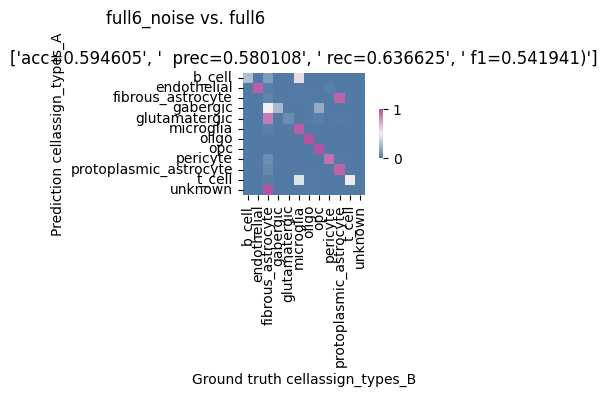

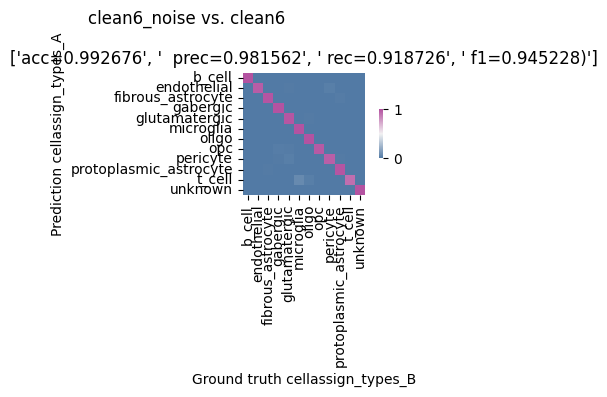

In [8]:
samp_set = "full"
samp_set = "clean"
noise = "_noise"
noise = ""
rep = 6

for samp_set in ["full", "clean"]:
    noise = "_noise"
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    noise = ""
    B = f"{samp_set}{rep}{noise}"
    filenB = root_path / f"testing/{B}_predictions.feather"
    predictionsB = pd.read_feather(filenB)

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
    )
    print_count_group(predictionsA, predictionsB, labs=[A, B])
    plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

#### implications

For the "clean" samples choosing batch correction with continuous covariates (`noise`) doesn't make much of a difference.  However for the "full" set of samples it is crucial.  It seems reasonabl the the "dirty" samples drive this need for more involved batch correction.


### Vanilla and "Noise" sets  Clean vs. Full ("_noise")

 N samples clean6_noise= 840710, N samples full6_noise= 2012744
   (underscore `_` indicates samples matched to clean6_noise samples)
                        clean6_noisepct  full6_noisepct  full6_noisepct_  \
cellassign_types                                                           
oligo                         40.813122       36.448003        40.808483   
glutamatergic                 30.519918       34.424895        30.553580   
gabergic                       7.338321        7.622529         7.353427   
opc                            5.674727        5.866320         5.665093   
protoplasmic_astrocyte         5.657480        6.303136         5.750140   
microglia                      5.588848        5.125391         5.584922   
fibrous_astrocyte              3.153882        2.684395         3.031010   
endothelial                    0.961330        1.190862         0.964066   
pericyte                       0.286544        0.328060         0.284640   
t_cell                        

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean6= 840710, N samples full6= 2012744
   (underscore `_` indicates samples matched to clean6 samples)
                        clean6pct   full6pct  full6pct_  clean6  full6_
cellassign_types                                                       
oligo                   40.938730  36.775218  41.118459  344176  345687
glutamatergic           30.186152   2.824949   3.233814  253778   27187
gabergic                 7.465000   2.107422   2.219315   62759   18658
protoplasmic_astrocyte   5.711720   8.778811   8.594521   48019   72255
microglia                5.590989   5.042569   5.521761   47004   46422
opc                      5.577785   8.269805   7.977067   46893   67064
fibrous_astrocyte        3.209787  34.569374  29.973237   26985  251988
endothelial              0.953480   1.166517   0.947532    8016    7966
pericyte                 0.358744   0.402138   0.349704    3016    2940
t_cell                   0.007018   0.005018   0.004163      59      35
unknown             

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


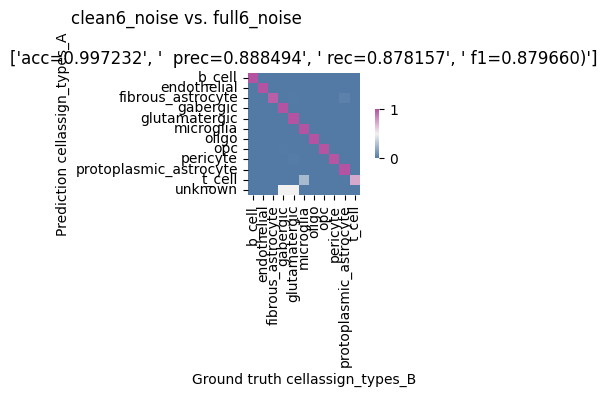

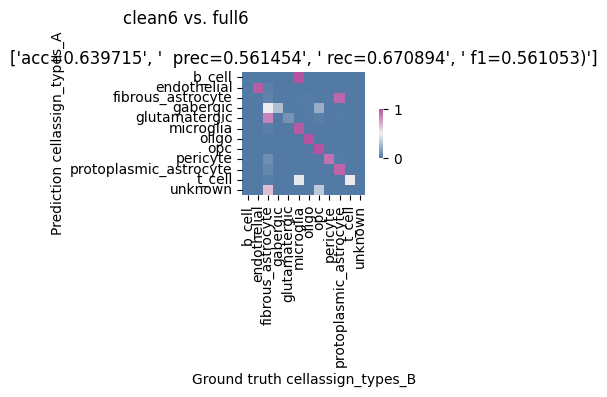

In [9]:
samp_set = "full"
samp_set = "clean"
noise = "_noise"
noise = ""
rep = 6

for noise in ["_noise", ""]:
    samp_set = "clean"
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    samp_set = "full"
    B = f"{samp_set}{rep}{noise}"
    filenB = root_path / f"testing/{B}_predictions.feather"
    predictionsB = pd.read_feather(filenB)

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="left", suffixes=("_A", "_B")
    )
    print_count_subset(predictionsA, predictionsB, labs=[A, B])
    plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

#### implications

_Without_ the `noise` batch correction the full dataset (presumably driven by the "dirty" samples) classify many of the neurons as "fibrous_astrocytes" and there is very poor correspondence between the "clean" samples when fit _with_ the "dirty" samples versus alone.  However _with_ batch correction including continuous `noise` covariates (`["doublet_score", "pct_counts_mt", "pct_counts_rb"]` ) the cell type assignments are overal quite accurate between the two datasets.   The notable exception are the "unknown", "t_cell" and "b_cell" assigned cells.  However these represent extremely rare cell types according to this dataset and assignment.

## conclusions

For "ground truth" assignments fitting cellassign with the continusous `noise` covariates on the "full" dataset should give us the most reasonable ground truth. 

Next steps:
- consider further simplified 
- consider alternate ground truth assignment methods which might leverage additional priors.  Here we are only constrained by consistency and the assumed marker genes
- estimate baseline performance of this ground truth designation procedure by analyzing the stability of assignments with different seed values. 

## repeatability...

 N samples full0_noise= 2012744, N samples full1_noise= 2012744
                        full0_noisepct  full1_noisepct  full0_noise  \
cellassign_types                                                      
oligo                        36.439309       36.430018       733430   
glutamatergic                34.417343       34.422361       692733   
gabergic                      7.594259        7.581689       152853   
protoplasmic_astrocyte        6.308800        6.306366       126980   
opc                           5.909644        5.936224       118946   
microglia                     5.124994        5.121963       103153   
fibrous_astrocyte             2.675601        2.679625        53853   
endothelial                   1.195433        1.188179        24061   
pericyte                      0.329600        0.328010         6634   
t_cell                        0.004770        0.005018           96   
b_cell                        0.000248        0.000348            5   

            

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean0_noise= 840710, N samples clean1_noise= 840710
                        clean0_noisepct  clean1_noisepct  clean0_noise  \
cellassign_types                                                         
oligo                         40.872001        40.807294        343615   
glutamatergic                 33.245828        30.481022        279501   
opc                            8.348063         5.739791         70183   
protoplasmic_astrocyte         5.645823         5.684838         47465   
microglia                      5.596936         5.592416         47054   
fibrous_astrocyte              3.152454         3.130330         26503   
gabergic                       1.790748         7.313342         15055   
endothelial                    0.977626         0.962401          8219   
pericyte                       0.362908         0.287376          3051   
t_cell                         0.003925         0.000119            33   
b_cell                         0.003687         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean0= 840710, N samples clean1= 840710
                        clean0pct  clean1pct  clean0  clean1
cellassign_types                                            
oligo                   41.007006  40.974058  344750  344473
glutamatergic           33.624318  32.370258  282683  272140
opc                      6.045604   6.067134   50826   51007
protoplasmic_astrocyte   5.720165   5.702085   48090   47938
gabergic                 4.535809   4.742182   38133   39868
b_cell                   4.517610   0.001546   37980      13
fibrous_astrocyte        3.212047   3.222395   27004   27091
endothelial              0.958000   0.945748    8054    7951
pericyte                 0.367190   0.368736    3087    3100
microglia                0.012133   5.599791     102   47078
unknown                  0.000119   0.000238       1       2


/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


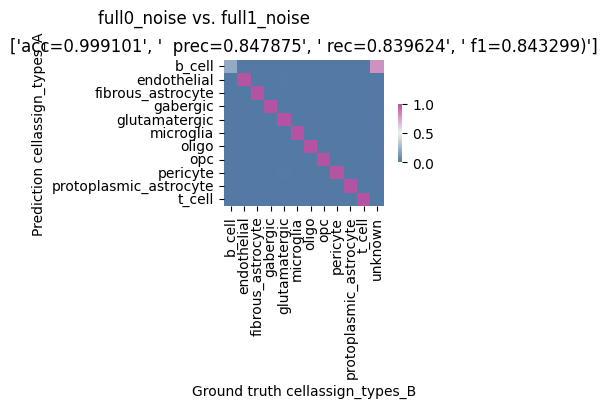

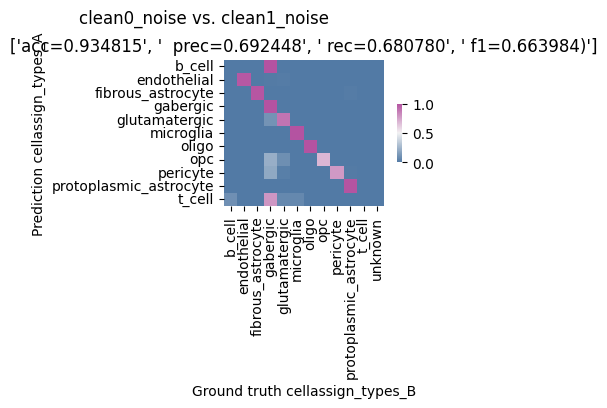

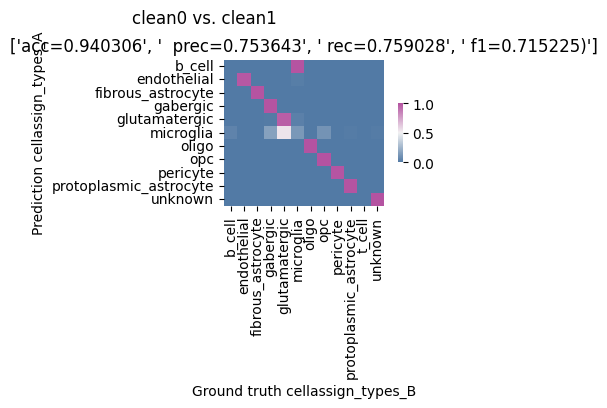

In [10]:
# full nooise, clean noise, clean naive
# compare seed 0 and seed 1

for samp_set in ["full", "clean"]:
    for noise in ["_noise", ""]:
        if samp_set == "full" and noise == "":
            continue
        rep = 0
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)

        rep = 1
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        merged_predictions = pd.merge(
            predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
        )
        print_count_group(predictionsA, predictionsB, labs=[A, B])
        plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

### results

Seems to be some great confusion between immune cells:  microglia, t_cell, b_cell, for the clean dataset without the noise parameters.



 N samples full1_noise= 2012744, N samples full2_noise= 2012744
                        full1_noisepct  full2_noisepct  full1_noise  \
cellassign_types                                                      
oligo                        36.430018       36.419634       733243   
glutamatergic                34.422361       31.830973       692834   
gabergic                      7.581689       10.434809       152600   
protoplasmic_astrocyte        6.306366        6.331655       126931   
opc                           5.936224        5.635441       119481   
microglia                     5.121963        5.132794       103092   
fibrous_astrocyte             2.679625        2.687674        53934   
endothelial                   1.188179        1.195780        23915   
pericyte                      0.328010        0.326221         6602   
t_cell                        0.005018        0.004223          101   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1_noise= 840710, N samples clean2_noise= 840710
                        clean1_noisepct  clean2_noisepct  clean1_noise  \
cellassign_types                                                         
oligo                         40.807294        40.905544        343071   
glutamatergic                 30.481022         4.470864        256257   
gabergic                       7.313342        30.068989         61484   
opc                            5.739791         8.767946         48255   
protoplasmic_astrocyte         5.684838         5.622985         47793   
microglia                      5.592416         5.608831         47016   
fibrous_astrocyte              3.130330         3.126881         26317   
endothelial                    0.962401         0.960260          8091   
pericyte                       0.287376         0.328651          2416   
b_cell                         0.000714         0.001546             6   
unknown                        0.000357         

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1= 840710, N samples clean2= 840710
                        clean1pct  clean2pct  clean1    clean2
cellassign_types                                              
oligo                   40.974058  41.047805  344473  345093.0
glutamatergic           32.370258  22.801323  272140  191693.0
opc                      6.067134   5.586944   51007   46970.0
protoplasmic_astrocyte   5.702085   5.754065   47938   48375.0
microglia                5.599791   5.611091   47078   47173.0
gabergic                 4.742182  14.655589   39868  123211.0
fibrous_astrocyte        3.222395   3.220016   27091   27071.0
endothelial              0.945748   0.959189    7951    8064.0
pericyte                 0.368736   0.361361    3100    3038.0
t_cell                   0.005828   0.002617      49      22.0
b_cell                   0.001546        NaN      13       NaN
unknown                  0.000238        NaN       2       NaN


/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


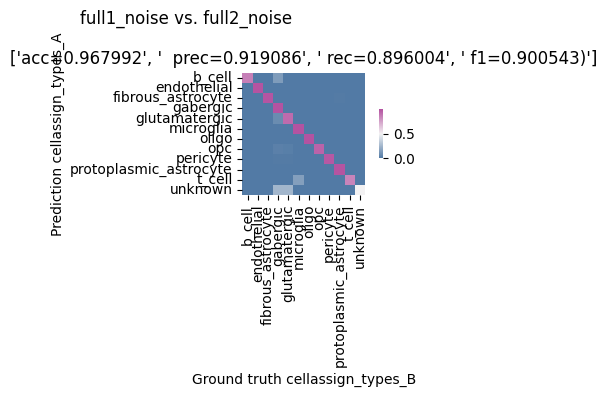

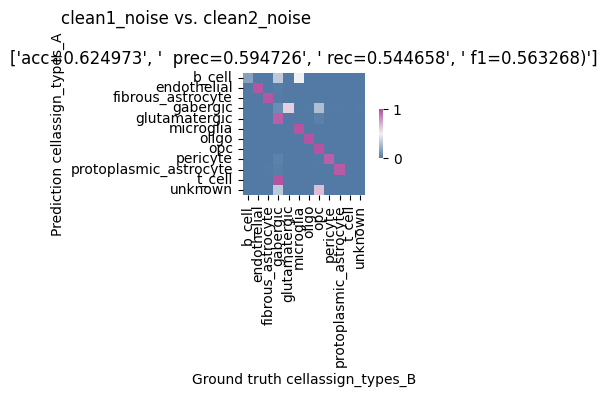

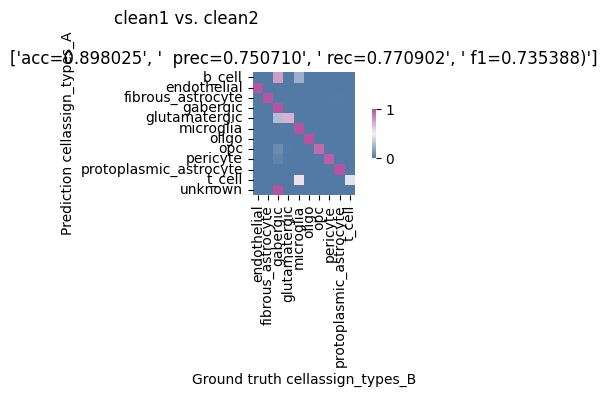

In [11]:
# full nooise, clean noise, clean naive
# compare seed 0 and seed 1

for samp_set in ["full", "clean"]:
    for noise in ["_noise", ""]:
        if samp_set == "full" and noise == "":
            continue
        rep = 1
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)

        rep = 2
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        merged_predictions = pd.merge(
            predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
        )
        print_count_group(predictionsA, predictionsB, labs=[A, B])
        plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")